In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy
from skimage.util import random_noise
from scipy.ndimage import median_filter

In [8]:
def extractAndResizeVideoFrame(cap):
    

    _, frame = cap.read()

    grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frame = cv2.resize(grayFrame, None, fx=0.5, fy=0.5)

    return frame.astype(np.uint8)

def trackFeatures(I, detector, maxCorners, qualityLevel, minDistance):
  if detector=="harris":
    useHarrisDetector = True
  else: 
    useHarrisDetector=False
    
  features = cv2.goodFeaturesToTrack(I, maxCorners, qualityLevel, minDistance, mask=None, blockSize=7, useHarrisDetector=useHarrisDetector)
  return features


def showInterestPoints(image, corners):
  img = image.copy()

  plt.imshow(img, cmap='gray')
  for i in corners:
      x,y = i.ravel()
      circle = plt.Circle((x,y), color='r')
      plt.gcf().gca().add_artist(circle)
  plt.show()


def snpAmount(x):
  return x/90.0 + 0.3

In [9]:
cap = cv2.VideoCapture("Team30.mp4")
frame = extractAndResizeVideoFrame(cap)
cap.release()
print(frame.shape)

(360, 640)


In [11]:
firstFrame = frame

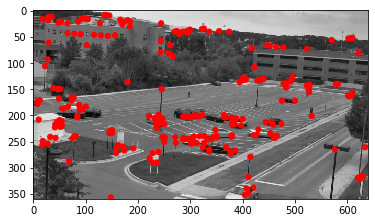

In [12]:
corners = trackFeatures(firstFrame, 'shi-tomasi',maxCorners = 500, qualityLevel = 0.15, minDistance = 3)
showInterestPoints(firstFrame, corners)

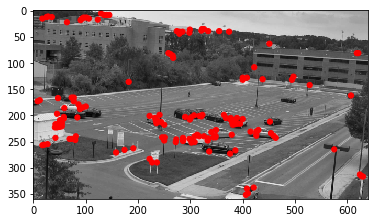

In [13]:
corners_h = trackFeatures(firstFrame,'harris',maxCorners = 1000, qualityLevel = 0.05, minDistance = 3)
showInterestPoints(firstFrame, corners_h)

# Relevant Paper: https://ieeexplore.ieee.org/document/323794

Επιλέξαμε μεγάλο αριθμό στο maxCorners, ώστε ο αλγόριθμος να μας επιστέψει πολλές γωνίες. Το min distance σημαίνει ότι κά

In [33]:
def calculateOpticalFlow(path, detector='shi-tomasi', updateInterval=-1, noise=False, denoise=False):
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    color = (0, 255, 0)

    cap = cv2.VideoCapture(path)

    ret, first_frame = cap.read()
    
    if noise:
        first_frame = random_noise(first_frame, mode='s&p',seed=1, amount=snpAmount(x))
        first_frame *= 255
        first_frame = first_frame.astype(np.uint8)


    first_frame = cv2.resize(first_frame, None, fx=0.5, fy=0.5)
    # Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

    # Finds the strongest corners in the first frame by Shi-Tomasi method - we will track the optical flow for these corners
    if detector == 'shi-tomasi':
        prev = trackFeatures(firstFrame, 'shi-tomasi',maxCorners = 500, qualityLevel = 0.15, minDistance = 3)
    elif detector == 'harris':
        prev = trackFeatures(firstFrame,'harris',maxCorners = 1000, qualityLevel = 0.05, minDistance = 3)
    else:
        print('Wrong estimator name')
        return -1 
    
    # Creates an image filled with zero intensities with the same dimensions as the frame - for later drawing purposes
    
    if denoise:
        prev_gray = median_filter(prev_gray, size=5)

    count = 0
    while(cap.isOpened()):
        mask = np.zeros_like(first_frame)


        ret, frame = cap.read()
        
        if noise:
            frame = random_noise(frame, mode='s&p',seed=1, amount=snpAmount(x))
            frame *= 255
            frame = frame.astype(np.uint8)

        frame = cv2.resize(frame, None, fx=0.5, fy=0.5)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if denoise:
            gray = median_filter(gray, size=5)

        # Calculates sparse optical flow by Lucas-Kanade method
        next, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev, None, **lk_params)

        # Selects good feature points for previous position
        good_old = prev[status == 1]

        # Selects good feature points for next position
        good_new = next[status == 1]

        # Draws the optical flow tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            # a, b = coordinates of new point
            a, b = new.ravel()

            # a, b = coordinates of old point
            c, d = old.ravel()

            # Draws line between new and old position with green color and 2 thickness
            mask = cv2.line(mask, (a, b), (c, d), color, 2)

            # Draws filled circle (thickness of -1) at new position with green color and radius of 3
            frame = cv2.circle(frame, (a, b), 3, color, -1)

        # Overlays the optical flow tracks on the original frame
        output = cv2.add(frame, mask)

        # Updates previous frame
        prev_gray = gray.copy()

        # Updates previous good feature points
        prev = good_new.reshape(-1, 1, 2)
        
        if updateInterval > 0 and count % updateInterval == 0:
            print(count)
            if detector == 'shi-tomasi':
                prev = trackFeatures(firstFrame, 'shi-tomasi',maxCorners = 500, qualityLevel = 0.15, minDistance = 3)
            elif detector == 'harris':
                prev = trackFeatures(firstFrame,'harris',maxCorners = 1000, qualityLevel = 0.05, minDistance = 3)
                

        # Opens a new window and displays the output frame
        plt.figure()
        plt.imshow(output)
        plt.savefig('lk/' + str(count).zfill(4) +'.png')
        plt.close()
        count += 1
    
    cap.release()

In [34]:
def create_vid(path, output):
    img_array = []
    files = sorted(os.listdir(path))

    
    if '.ipynb_checkpoints' in files:
        files.remove('.ipynb_checkpoints')
        
    for filename in files:
        #print(filename)
        img = cv2.imread(path + '/' + filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)


    out = cv2.VideoWriter(output+'.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 30.0, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [ ]:
#ΑΜ πρώτου μέλους: 03116641, αρα το seed θα είναι 1 και το x θα είναι 4
seed = 1
x = 4
calculateOpticalFlow("Team30.mp4", detector='shi-tomasi', updateInterval=30, noise=True, denoise=True)  

0
30
60
90
120


In [28]:
create_vid('lk', 'project')